## MT3DMS Problem 8

The purpose of this script is to (1) recreate the example problems that were first
described in the 1999 MT3DMS report, and (2) compare MF6-GWT solutions to the
established MT3DMS solutions.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130.
This notebook demonstrates example 8 from the list below:

  1. One-Dimensional Transport in a Uniform Flow Field
  2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
  3. Two-Dimensional Transport in a Uniform Flow Field
  4. Two-Dimensional Transport in a Diagonal Flow Field
  5. Two-Dimensional Transport in a Radial Flow Field
  6. Concentration at an Injection/Extraction Well
  7. Three-Dimensional Transport in a Uniform Flow Field
  8. _Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer_
  9. Two-Dimensional Application Example
  10. Three-Dimensional Field Case Study

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-mt3dms-p08"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = pl.Path(f"../data/{sim_name}")
data_path = data_path if data_path.is_dir() else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlay = 27  # Number of layers
nrow = 1  # Number of rows
ncol = 50  # Number of columns
delr = 5.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delz = 0.25  # Layer thickness ($m$)
top = 6.75  # Top of the model ($m$)
prsity = 0.35  # Porosity
dm = 5.0e-4  # Horiz. hyd. conductivity of fine grain material ($cm/sec$)
dm = 1.0e-2  # Horiz. hyd. conductivity of medium grain material ($cm/sec$)
rech = 10.0  # Applied recharge rate ($cm/yr$)
al = 0.5  # Longitudinal dispersivity ($m$)
tral = 0.005  # Transverse vertical dispersivity ($m$)
dmcoef = 1.34e-5  # Effective diffusion coefficient ($cm^2/sec$)
perlen = 20.0  # Simulation time ($years$)

# Additional model input
k1 = 5e-4 / 100.0 * 86400  # m/d
k2 = 1e-2 / 100.0 * 86400  # m/d
k11 = k1 * np.ones((nlay, nrow, ncol), dtype=float)
k11[11:19, :, 0:24] = k2
k11[11:19, :, 36:] = k2
laytyp = 6 * [1] + 21 * [0]
# Setting starting head information
fname = "p08shead.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:673d570ab9d496355470ac598c4b8b55",
)
f = open(fpath)
strt = np.empty((nlay * ncol), dtype=float)
strt = read1d(f, strt).reshape((nlay, nrow, ncol))
f.close()
# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[5:, :, -1] = -1
ibound[strt < 0] = 0
idomain = 1
# Fow boundary condition
rech = 10.0 / 100 / 365  # cm/yr -> m/d
# Transport relate`xd
trpt = 0.01  # Ratio of transverse to longitudinal dispersitivity
trpv = 0.01  # Ratio of vertical to longitudinal dispersitivity
dmcoef = 1.34e-5 / 100 / 100 * 86400  # cm^2/s -> m^2/d
ath1 = al * trpt
atv = al * trpv
# Time variables
perlen = [5 * 365, 15 * 365]
nper = len(perlen)
nstp = [365, 1095]
tsmult = [1.0, 1.0]

sconc = 0.0
c0 = 0.0
botm = [top - delz * k for k in range(1, nlay + 1)]
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
icelltype = 6 * [1] + 21 * [0]
mixelm = -1

# Boundary conditions
# MF6 constant head boundaries:
chdspd = []
# Left side of model domain is no flow; right side uses constant heads
for k in np.arange(nlay):
    if strt[k, 0, -1] != -999:
        #              (l, r,  c),               head, conc
        chdspd.append([(k, 0, ncol - 1), strt[k, 0, -1], 0.0])

chdspd = {0: chdspd}

# SSM related input data
crch1 = np.zeros((nrow, ncol), dtype=float)
crch1[0, 9:18] = 1.0
cnc0 = [(0, 0, j, 1, -1) for j in range(8, 16)]
cnc1 = [(0, 0, j, 0.0, -1) for j in range(8, 16)]
ssmspd = {0: cnc0, 1: cnc1}
# Setup constant concentration information for MF6
cncspd_1 = []
cncspd_2 = []
cnc_1 = 1.0  # t <= 5 yrs
cnc_2 = 0.0  # t >  5 yrs
for col in np.arange(8, 16):
    cncspd_1.append([(0, 0, col), cnc_1])  # t <= 5 yrs
    cncspd_2.append([(0, 0, col), cnc_2])  # t > 5 yrs

cncspd = {0: cncspd_1, 1: cncspd_2}

# Solver settings
nouter = 100
ninner =  300
hclose = 1e-6
rclose = 1e-6
relax =  1.0
percel = 1.0  # HMOC parameters
itrack = 3
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 10
npmin = 2
npmax = 20
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph

# Time discretization
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(mixelm=0, silent=False):
    print(f"Building mf2005 model...{sim_name}")
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p08-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        nstp=nstp,
        perlen=perlen,
        itmuni=4,
        lenuni=2,
        steady=[False, False],
    )

    # Instantiate basic package
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=k11, vka=k11, laytyp=icelltype)

    # Instantiate recharge package
    flopy.modflow.ModflowRch(mf, rech=rech)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Transport
    print(f"Building mt3d-usgs model...{sim_name}")
    modelname_mt = "p08_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dusgs",
        modflowmodel=mf,
    )

    # Instantiate basic transport package
    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=sconc,
        nper=nper,
        perlen=perlen,
        timprs=np.arange(1, 21) * 365,
        dt0=5,
    )

    # Instantiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        wd=wd,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)

    # Instantiate the source/sink mixing package
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssmspd)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt)

    # MODFLOW 6
    print(f"Building mf6gwt model...{sim_name}")
    name = "p08_mf6"
    gwfname = "gwf_" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=hclose,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=ninner,
        relaxation_factor=relax,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k11,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiate storage package
    sto = flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf,
        print_flows=True,
        recharge=rech,
        pname="RCH-1",
        filename=f"{gwfname}.rch",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt_" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=hclose,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=ninner,
        relaxation_factor=relax,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("CONCENTRATION", "LAST"),
            (
                "CONCENTRATION",
                "STEPS",
                "73",
                "146",
                "219",
                "292",
                "365",
                "438",
                "511",
                "584",
                "657",
                "730",
                "803",
                "876",
                "949",
                "1022",
                "1095",
                "1168",
                "1241",
                "1314",
                "1387",
                "1460",
            ),
            ("BUDGET", "LAST"),
        ],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiate constant concentration at upper boundary.
    flopy.mf6.ModflowGwtcnc(
        gwt,
        print_flows=True,
        stress_period_data=cncspd,
        pname="CNC-1",
        filename=f"{gwtname}.cnc",
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 7)


def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # Get the MF6 concentration output
    gwt = mf6.get_model(list(mf6.model_names)[1])
    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        hk = mf2k5.lpf.hk.array
        # Which year to plot?:
        yr_idx = [7, 11, 19]  # 0-based

        contourLevels = np.arange(0.05, 0.5, 0.05)

        # Plot after 8 years
        i = 0
        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(2, 1, 1)
            axWasNone = True

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 2)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-{yr_idx[i] + 1}yrs.png"
            fig.savefig(fpth)

        # Plot after 12 years
        i = 1
        if axWasNone:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(2, 1, 1)
            axWasNone = True

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 3)
        styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 4)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-{yr_idx[i] + 1}yrs.png"
            fig.savefig(fpth)

        # Plot after 20 years
        i = 2
        if axWasNone:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(2, 1, 1)
            axWasNone = True

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 5)
        styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound()
        mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(
            conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]
        )
        plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 6)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-{yr_idx[i] + 1}yrs.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

Compares the standard finite difference solutions between MT3D and MF6.

Building mf2005 model...ex-gwt-mt3dms-p08
Building mt3d-usgs model...ex-gwt-mt3dms-p08
found 'rch' in modflow model, resetting crch to 0.0
Building mf6gwt model...ex-gwt-mt3dms-p08


run_models took 18235.23 ms


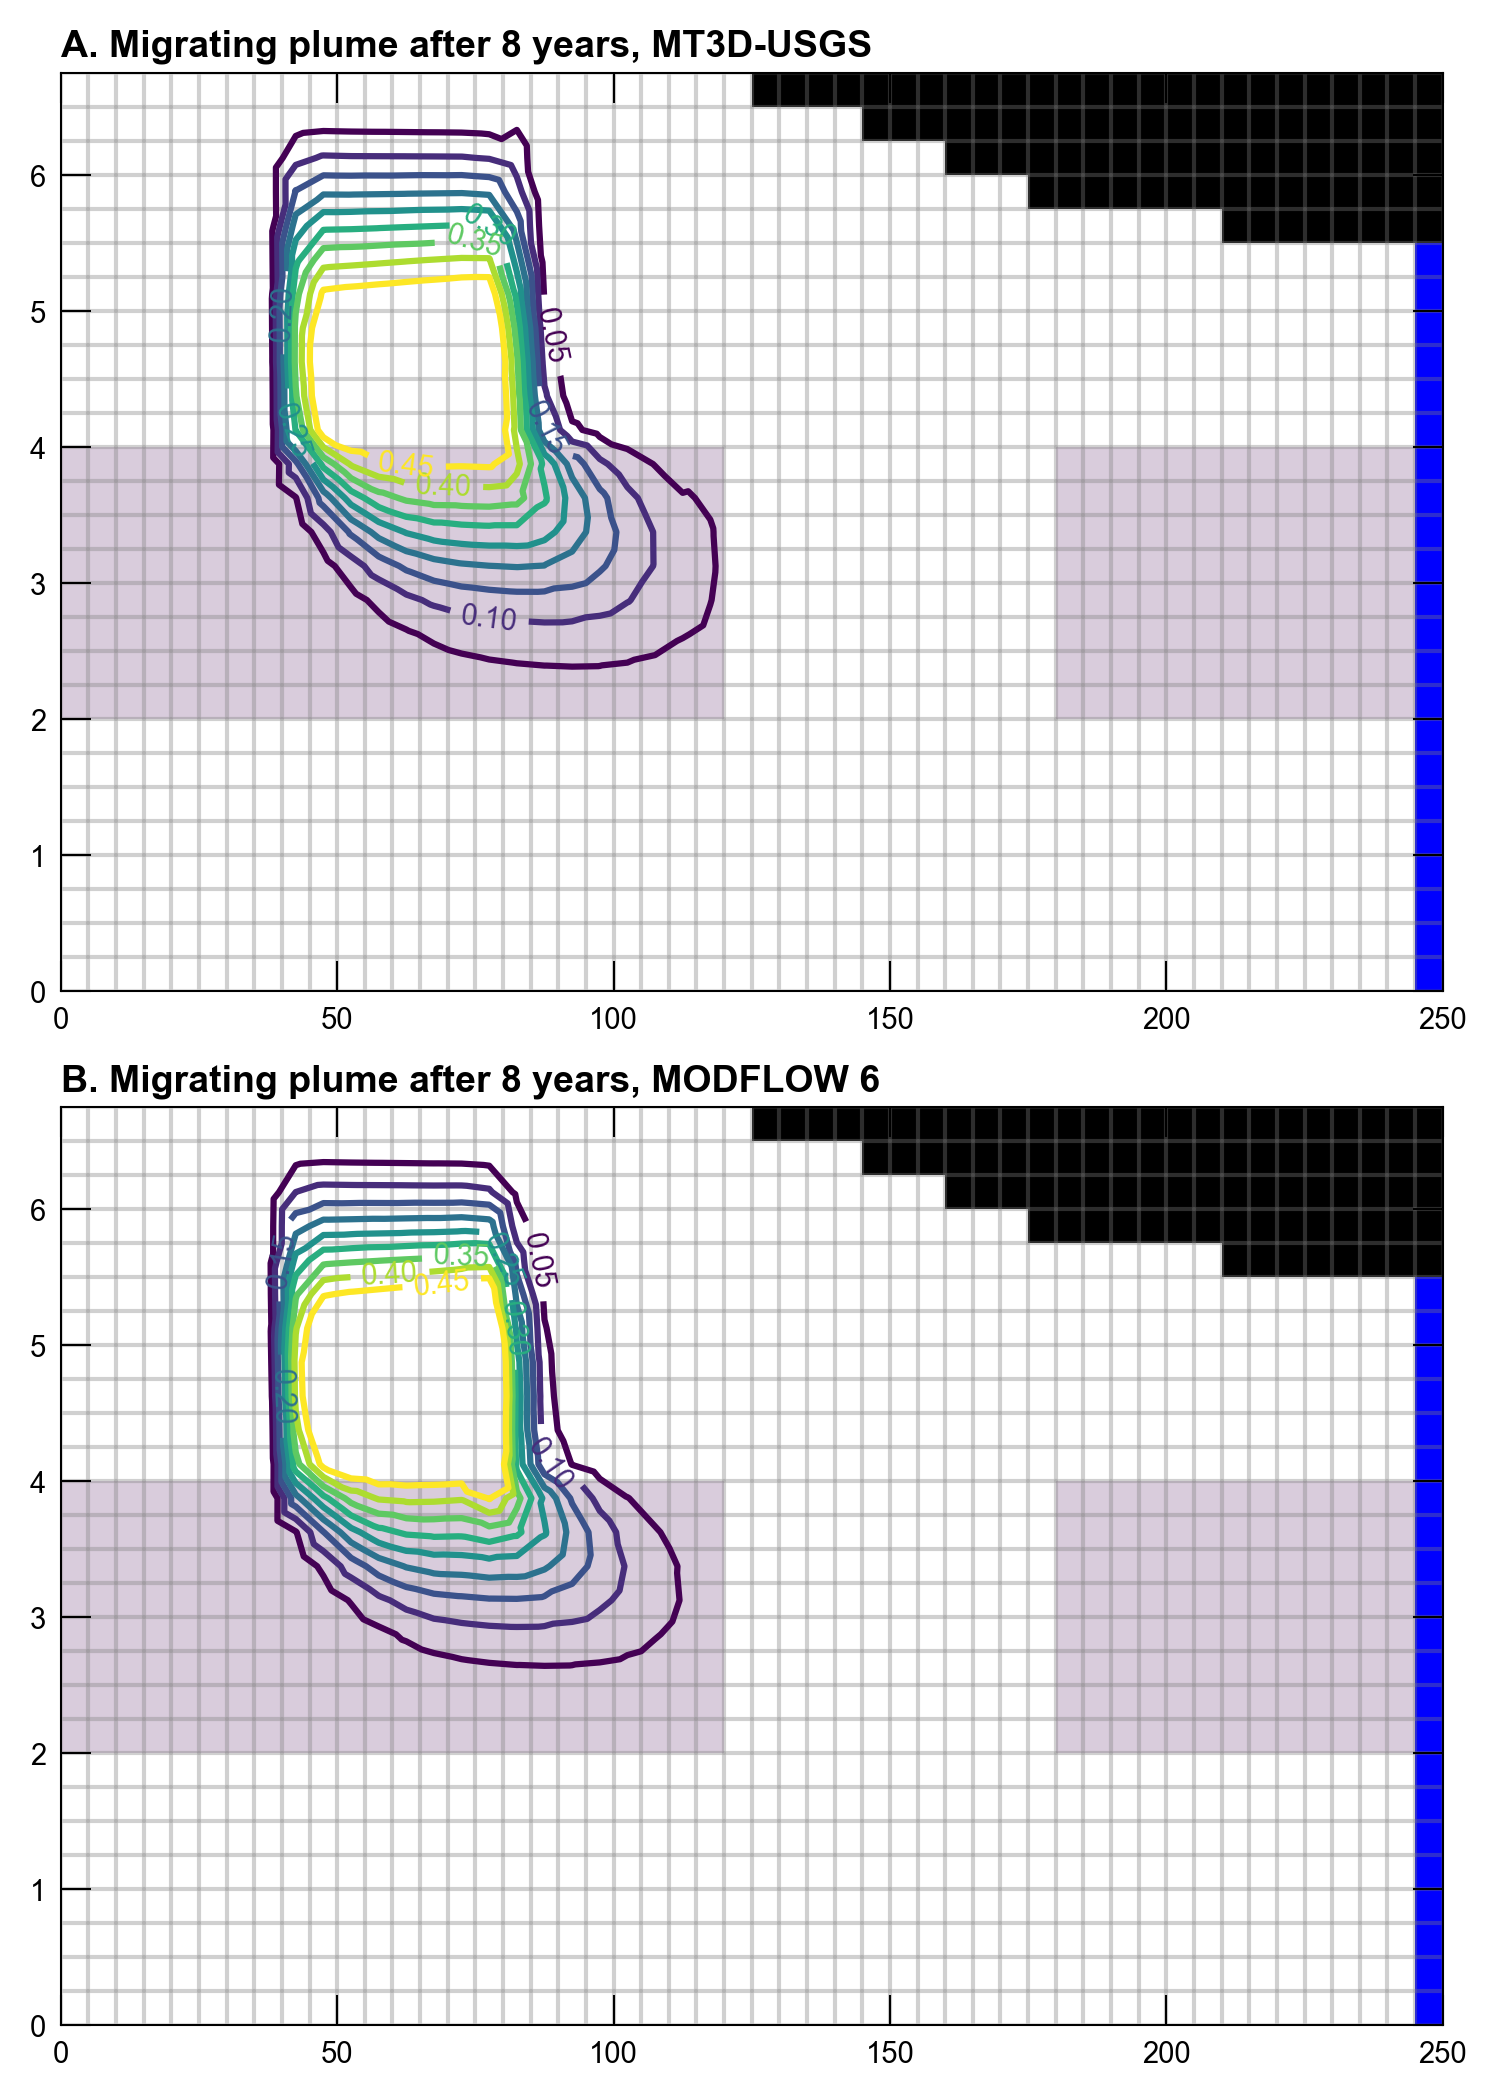

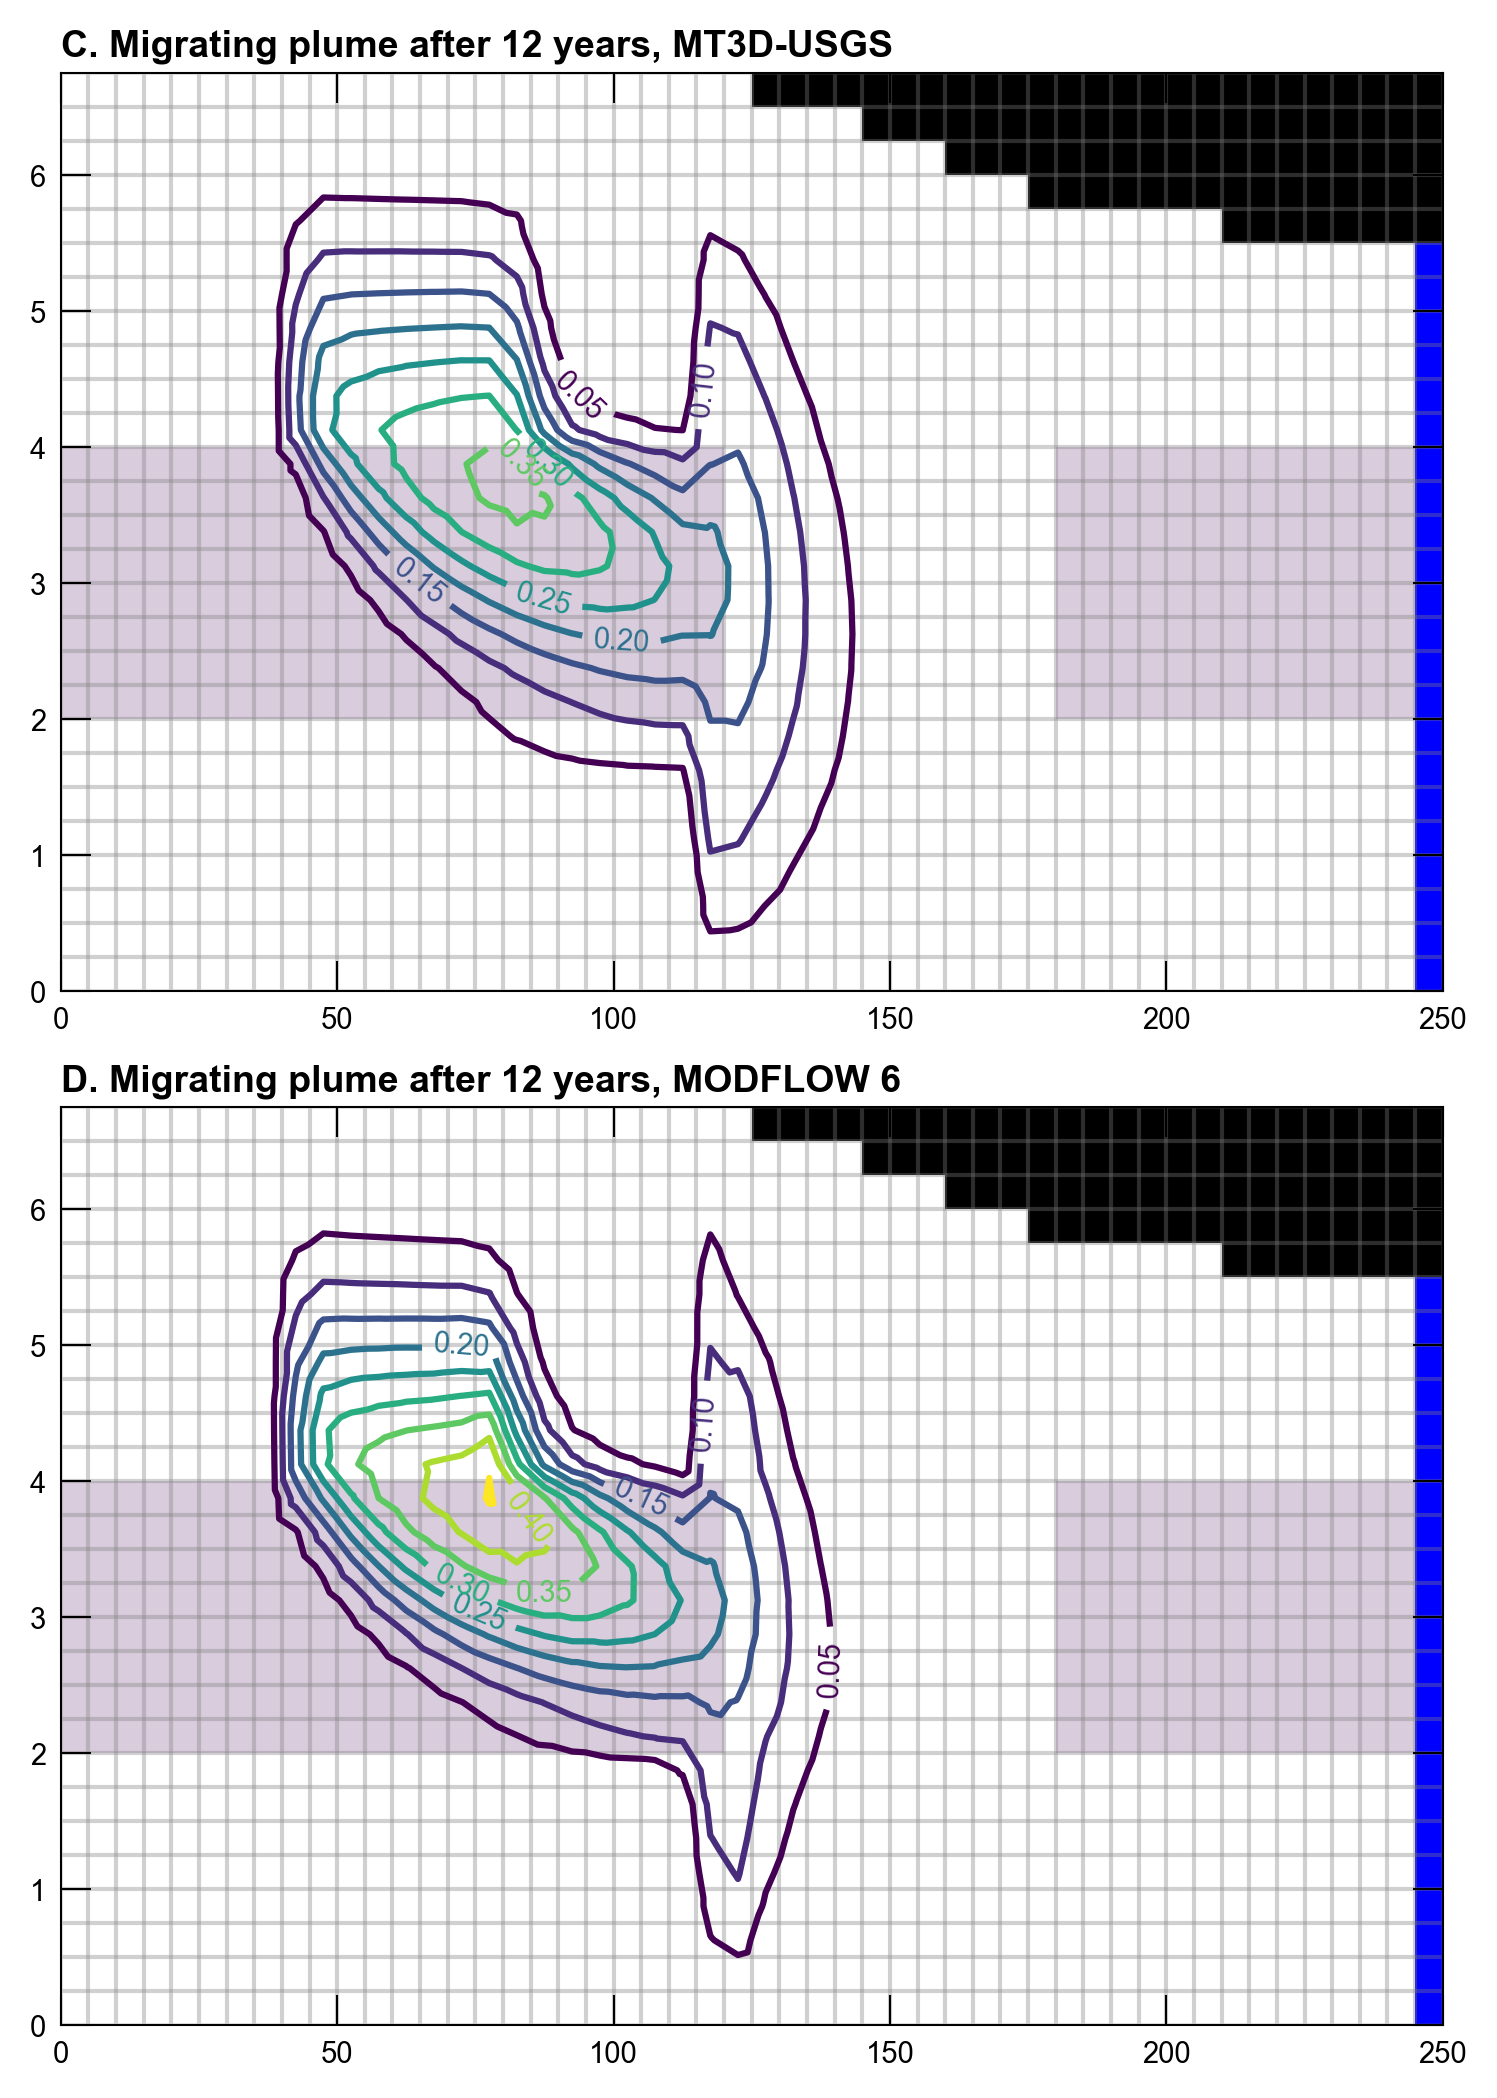

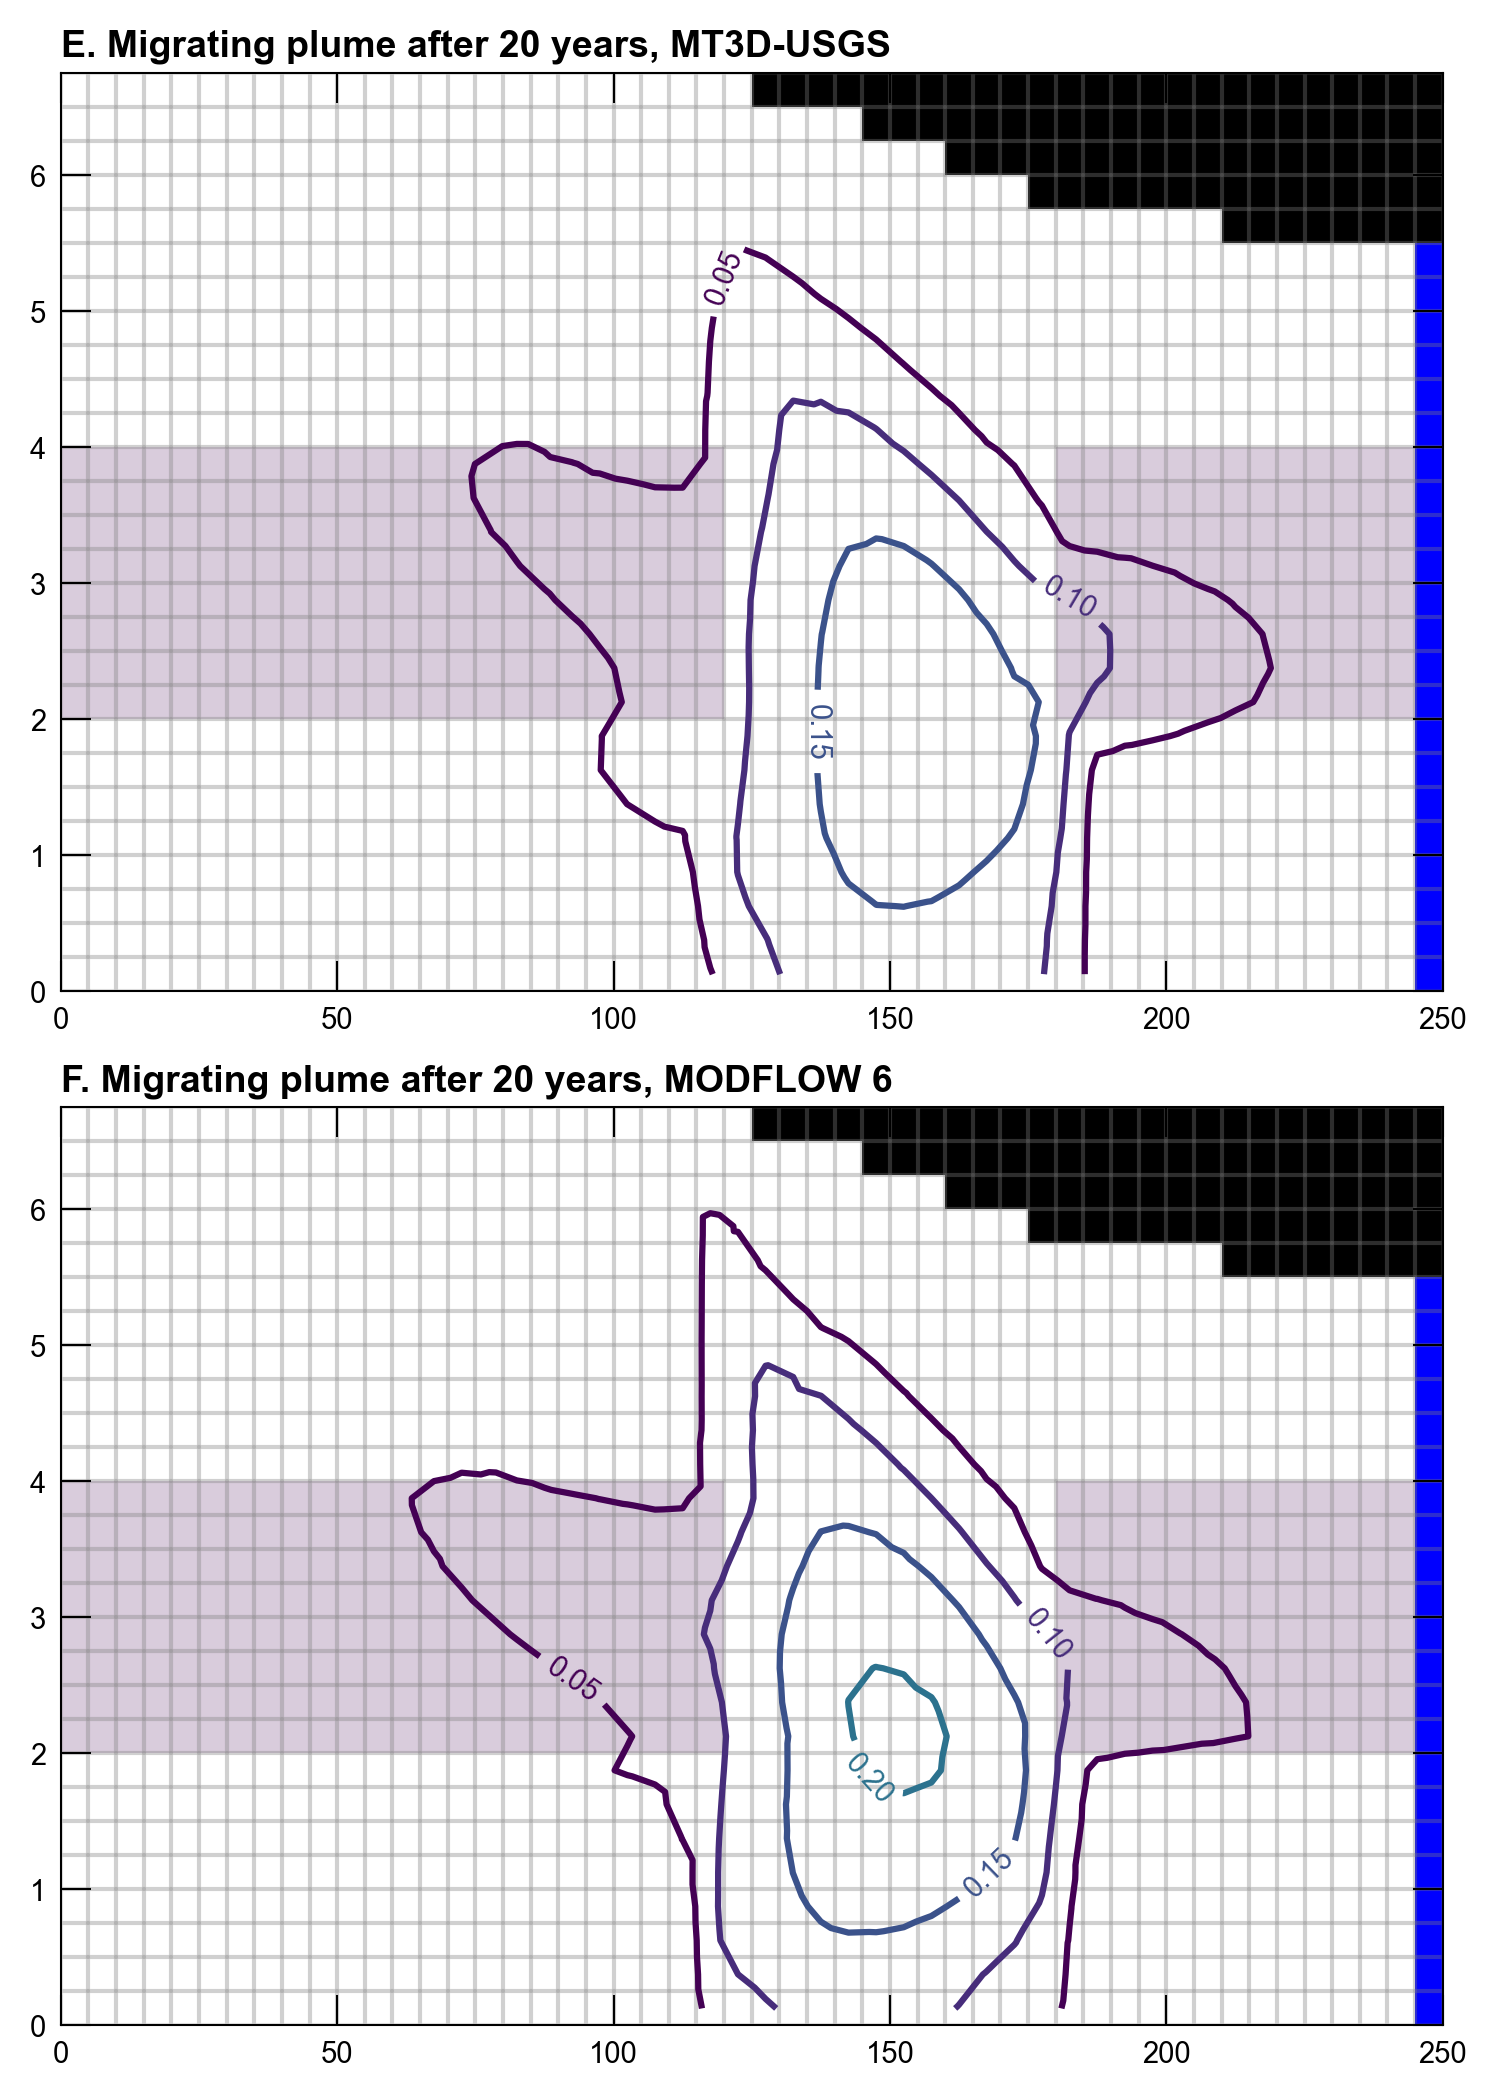

In [6]:
scenario(0, silent=True)